# **Data Science Fundación YPF + Ingenias**

# Energías Renovables en Argentina y su contribución al sistema eléctrico de todo el país.


## **Objetivo del proyecto:**
### “Predecir la contribución de las fuentes de energías renovables a la satisfacción de la demanda eléctrica del país.”

## **Origen del Dataset**:
El conjunto de datos utilizado se obtuvo de la página web de [CAMMESA](https://www.cammesa.com.ar/), la compañía argentina encargada de operar el mercado eléctrico mayorista. Éste incluye información sobre la energía generada por fuentes renovables en Argentina, así como su contribución al sistema eléctrico. También contiene datos sobre la demanda histórica de energía eléctrica en el país, desde 2011 hasta 2023.
La importancia de la producción de este tipo de energías está dada por las ventajas climáticas, ambientales y de salud humana que representan respecto a otras fuentes de energía tradicionales.

#### La base de datos abarca de forma mensual, desde enero de 2011 hasta junio de 2023, conteniendo los siguientes campos con una cantidad total de 15999 registros:

a) Central / máquina por región del país

b) Tipo de fuente de energía renovable (Hidro < 50 MW; Eólico, Solar, Biomasa, Biodiesel)

c)Provincia

d) Mes/Año

e) Energía Generada (GWh)

# Análisis Exploratorio de los datos

## 1. Instalar e importar los paquetes que vamos a necesitar para explorar y modificar los datos

In [1]:
!pip install fuzzywuzzy
#string matching
!pip install geopandas
#para trabajar con datos espaciales en python
!pip install contextily
#para tener mapas base para nuestras geometrias
!pip install seaborn
#visualización estadística
!pip install matplotlib mplcursors ipywidgets
!pip install ipywidgets
!pip install cartopy

     ---------------------------------------- 0.0/89.0 kB ? eta -:--:--
     ---------------------------------------- 89.0/89.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21201 sha256=d8657fefa6918252a8a296ba1100c73782ca30b56db55d27b4e0725ee12e8804
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\5d\a1\eb\b98ee80431eb8217a22381e1725048be8cd0385675b151be45
Successfully built mplcursors


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gdp
from fuzzywuzzy import fuzz, process
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider #Para generar el deslizador
import contextily as ctx #Para armar el mapa base.
from IPython.display import Markdown
import re
from sklearn.preprocessing import LabelEncoder

## 2.Preparación y limpieza de datos

In [3]:
#Leemos el archivo con el data set
er = pd.read_csv('../Datos/ER_v2.csv')

In [4]:
er.head(5)

,AÑO,CENTRAL,CENTRAL DESCRIPCIÓN,MAQUINA,FUENTE DE ENERGÍA,REGIÓN,PROVINCIA,MES,ENERGÍA GENERADA [GWh],Nueva Generación
0,2011,AESP,AES PARANA,AESPCC01,BIODIESEL,LITORAL,BUENOS AIRES,ene-11,0,Resto
1,2011,AESP,AES PARANA,AESPCC02,BIODIESEL,LITORAL,BUENOS AIRES,ene-11,0,Resto
2,2011,AMEGHI,F. AMEGHINO,AMEGHI,HIDRO <=50MW,PATAGONIA,CHUBUT,ene-11,13.8,Resto
3,2011,ARAUEO,ARAUCO EOLICO,ARAUEO,EOLICO,NOROESTE,LA RIOJA,ene-11,0.1,Resto
4,2011,CACVHI,C.H.CACHEUTA VI,CACVHI,HIDRO <=50MW,CUYO,MENDOZA,ene-11,0,Resto


In [5]:
#Cambiamos el nombre de las columnas para que sea de más fácil manipulación.
er.rename({"AÑO":"anio","CENTRAL":"central",
           "CENTRAL DESCRIPCIÓN":"central_des",
           "MAQUINA":"maquina",
           "FUENTE DE ENERGÍA":"fuente_de",
           "REGIÓN":"region",
           "ENERGÍA GENERADA [GWh]":"energia_gen",
           "Nueva Generación":"nueva_gen",
           "PROVINCIA":"prov",
           "MES":"mes"},
          axis='columns', inplace=True)
er.columns

Index(['anio', 'central', 'central_des', 'maquina', 'fuente_de', 'region',
       'prov', 'mes', 'energia_gen', 'nueva_gen'],
      dtype='object')

In [6]:
er.info() #información sobre cantidad de columnas, registros, y tipo de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15997 entries, 0 to 15996
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   anio         15997 non-null  int64 
 1   central      15997 non-null  object
 2   central_des  15997 non-null  object
 3   maquina      15997 non-null  object
 4   fuente_de    15997 non-null  object
 5   region       15997 non-null  object
 6   prov         15997 non-null  object
 7   mes          15997 non-null  object
 8   energia_gen  15997 non-null  object
 9   nueva_gen    15997 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.2+ MB


In [7]:
#Sacamos las filas correspondientes a la demanda total Demanda MEM
#Primero vemos que filas poseen Demanda MEM
index_mem=er[er["central"]=="Demanda MEM"].index #Indice de las filas que queremos eliminar
er.drop(index_mem,inplace=True) #Eliminamos esas filas

In [8]:
#Cambiamos el tipo de dato de la energía generada de objeto a float.
er["energia_gen"]=er["energia_gen"].astype('float64')

In [9]:
# Verificamos que no posee valores faltantes y ordenamos las columnas de mayor a menor.
missing_values = er.isnull().sum().sort_values(ascending = False)

missing_values

anio           0
central        0
central_des    0
maquina        0
fuente_de      0
region         0
prov           0
mes            0
energia_gen    0
nueva_gen      0
dtype: int64

In [10]:
# Cambiamos el formato del nombre de cada mes a su abreviatura en inglés ya que de esta forma permite covertirlo al datetime correspondiente.

# Reemplazar en la columna 'mes'
er['mes'] = er['mes'].str.replace('ene', 'jan')
er['mes'] = er['mes'].str.replace('abr', 'apr')
er['mes'] = er['mes'].str.replace('ago', 'aug')
er['mes'] = er['mes'].str.replace('dic', 'dec')

In [11]:
#Pasamos la informacion al formato datetime
er['mes']=pd.to_datetime(er['mes'],format='%b-%d').dt.month #Tomamos el mes, que queda representado con un numero.

er['anio']=pd.to_datetime(er['anio'],format='%Y').dt.year #Tomamos el año

In [12]:
#Analizamos de manera descriptiva la energía generada.

er['energia_gen'].describe() #estadística descriptiva

count    15847.000000
mean         5.535458
std         10.300713
min          0.000000
25%          0.000000
50%          1.500000
75%          6.000000
max        167.800000
Name: energia_gen, dtype: float64

Chequeamos la presencia de outliers

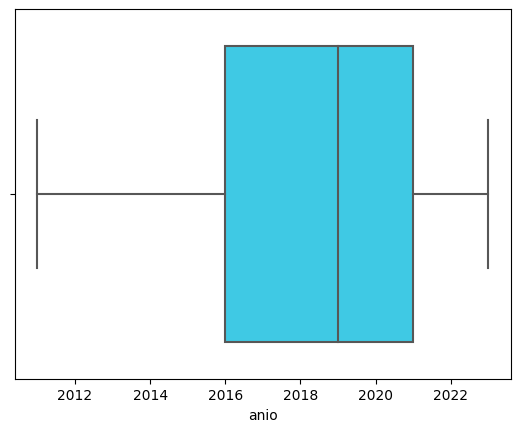

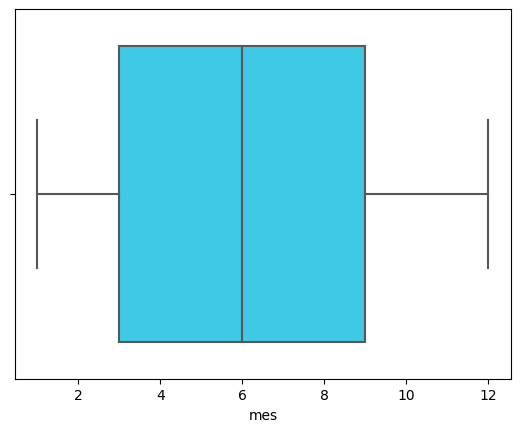

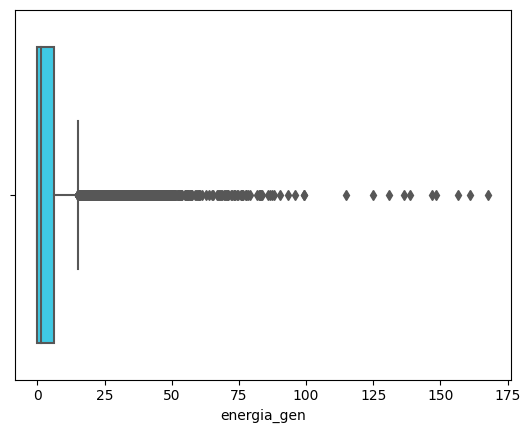

In [14]:
column_list = ['anio', 'mes', 'energia_gen']
for col in column_list:
    sns.set_palette('cool')
    sns.boxplot(x = er[col])
    plt.xlabel(col)
    plt.show()


Cuando se examinan los gráficos anteriores, se observa que hay valores atípicos en las variables energia_gen (energía generada). Sin embargo, estos valores atípicos no perjudican nuestro conjunto de datos. Por el contrario, estos datos nos permiten hacer comentarios sobre los datos de manera más fácil. Por lo tanto, no aplicamos ningún proceso a estos datos.

## 3.Visualización de los datos

## **Countplot::**

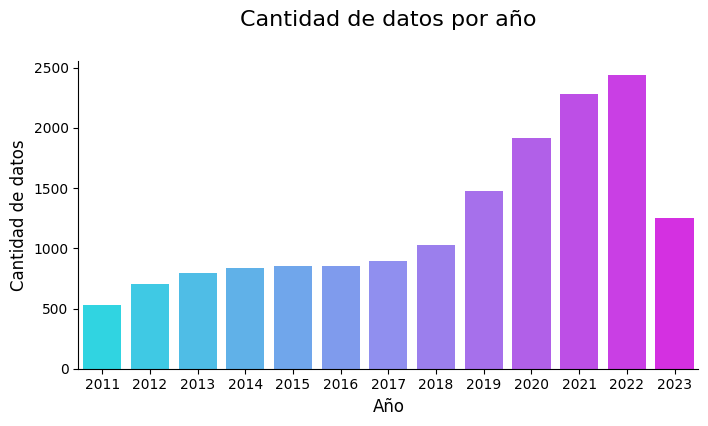

In [15]:
# Suma de la cantidad de datos generados por año
plt.figure(figsize=(8,4))
sns.countplot(x="anio", data=er, palette='cool')
plt.ylabel("Cantidad de datos", size=12)
plt.xlabel("Año", size=12)
plt.title("Cantidad de datos por año", size=16, pad=25)
sns.despine()

Podemos corroborar que en los últimos  años se ha incrementado exponencialmente la cantidad de información sobre energías renovables generadas en el país.

## **Barplot**

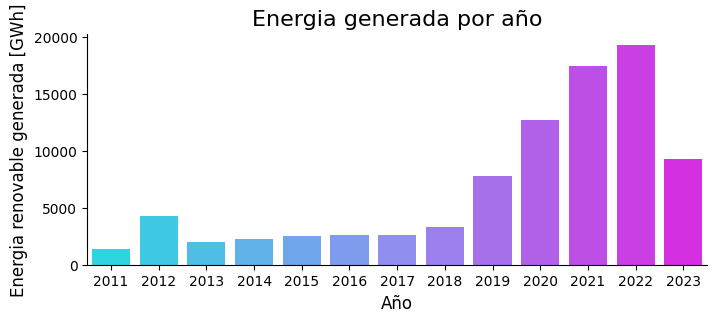

In [16]:
# Cantidad de energía renovable generada por año

# Filtramos los datos y sumamos
total_anio = er.groupby(['anio'])['energia_gen'].sum().reset_index()

plt.figure(figsize=(8,3))
sns.barplot(x = total_anio.anio ,y = total_anio.energia_gen, palette='cool')
plt.xlabel("Año", fontsize=12)
plt.ylabel("Energia renovable generada [GWh]", fontsize=12)
plt.title("Energia generada por año", fontsize=16)
sns.despine()

El gráfico muestra que en los últimos cuatro años la cantidad de energía generada por diversas fuentes renovables en el país se ha multiplicado.

## Gráfico de barras apiladas:

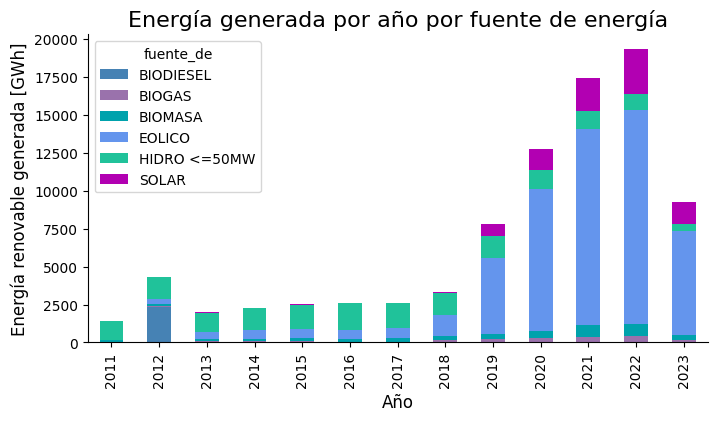

In [17]:
# Cantidad de energía renovable generada por año diferenciada por tipo de fuente de energía

# Filtramos los datos y sumamos
cat_anio = er.groupby(['anio','fuente_de'])[['energia_gen']].sum().reset_index()
df_cat_anio = cat_anio.pivot(index='anio', columns='fuente_de', values='energia_gen').fillna(0).reset_index()

# Gráfico de barras apiladas
colores = ['#4682B4','#9A72AC', '#00A2AC','#6495ED', '#20C29A','#B200B2']
df_cat_anio.set_index('anio').plot(kind='bar', stacked=True, figsize=(8,4), color=colores)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Energía renovable generada [GWh]", fontsize=12)
plt.title("Energía generada por año por fuente de energía", fontsize=16)
sns.despine()

En este gráfico, observamos cómo se desglosa el tipo de energía según su fuente. Se puede apreciar que la energía eólica ha experimentado un notable aumento en los últimos años, mientras que otros tipos de energía han experimentado incrementos más graduales.

## Gráfico de barras agrupadas por tipo energía y cantidad de máquinas

In [18]:
# Agrupar por las columnas maquina y fuente_de, y contar la cantidad de repeticiones
grouped = er.groupby(['maquina', 'fuente_de']).size().reset_index(name='CANTIDAD')
# Filtrar las filas donde fuente_de no sea igual a "Demanda MEM"
filtered_grouped = grouped[grouped['fuente_de'] != 'Demanda MEM']
# Imprimir el DataFrame resultante
print(filtered_grouped)


      maquina  fuente_de  CANTIDAD
0    ABBGDI01     BIOGAS        28
1        ABEF     BIOGAS         3
2    ABEFDI01     BIOGAS        25
3      ACHIEO     EOLICO        59
4    AESPCC01  BIODIESEL       150
..        ...        ...       ...
223    VSECEO     EOLICO        33
224  VTBGDI01     BIOGAS        34
225  YAN2DI01     BIOGAS        32
226  YANQDI01     BIOGAS        71
227    ZONDFV      SOLAR         3

[228 rows x 3 columns]


In [19]:
# Contar los valores distintos en las columnas maquina y fuente_de
maquina_distinct_count = filtered_grouped['maquina'].nunique()
fuente_energia_distinct_count = filtered_grouped['fuente_de'].nunique()

# Sumar la columna CANTIDAD
suma_cantidad = filtered_grouped['CANTIDAD'].sum()

# Imprimir los resultados
print(f"Número de valores distintos en la columna maquina: {maquina_distinct_count}")
print(f"Número de valores distintos en la columna fuente_de: {fuente_energia_distinct_count}")
print(f"Suma total de la columna CANTIDAD: {suma_cantidad}")

Número de valores distintos en la columna maquina: 228
Número de valores distintos en la columna fuente_de: 6
Suma total de la columna CANTIDAD: 15847


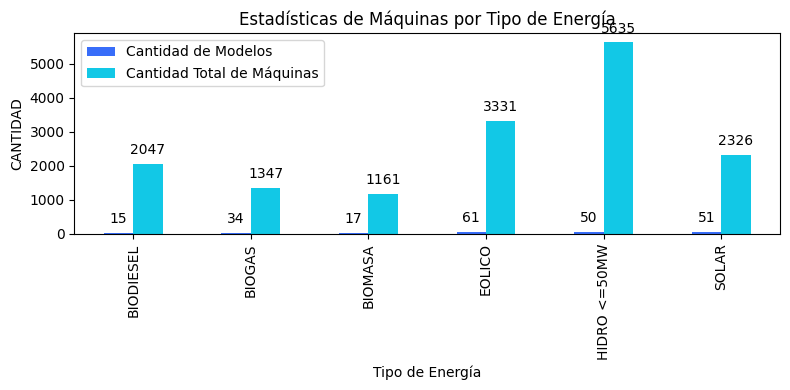

In [20]:
# Agrupar por fuente_de y contar la cantidad de modelos y la cantidad total de maquinas
energy_stats = filtered_grouped.groupby('fuente_de').agg({'maquina': 'count', 'CANTIDAD': 'sum'}).reset_index()

# Renombrar las columnas para mayor claridad
energy_stats.rename(columns={'maquina': 'Cantidad de Modelos', 'CANTIDAD': 'Cantidad Total de Máquinas'}, inplace=True)

# Crear el diagrama de barras agrupadas
sns.set_palette('rainbow')
fig, ax = plt.subplots(figsize=(8, 4))
energy_stats.plot(kind='bar', x='fuente_de', ax=ax)
ax.set_title('Estadísticas de Máquinas por Tipo de Energía')
ax.set_xlabel('Tipo de Energía')
ax.set_ylabel('CANTIDAD')
ax.legend(["Cantidad de Modelos", "Cantidad Total de Máquinas"])


# Agregar etiquetas con los valores en las barras
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

## Gráfico de líneas por tipo de energía y mes

In [21]:

# Seleccionar las columnas deseadas
columnas_deseadas = ['maquina', 'fuente_de', 'anio', 'mes']

# Agrupar por las columnas seleccionadas y contar la cantidad
grupo_df = er.groupby(columnas_deseadas).size().reset_index(name='CANTIDAD')

# Filtrar y eliminar filas donde fuente_de es igual a "Demanda MEM"
grupo_df_filtrado = grupo_df[grupo_df['fuente_de'] != 'Demanda MEM']

# Mostrar el DataFrame filtrado
print(grupo_df_filtrado)

        maquina fuente_de  anio  mes  CANTIDAD
0      ABBGDI01    BIOGAS  2021    3         1
1      ABBGDI01    BIOGAS  2021    4         1
2      ABBGDI01    BIOGAS  2021    5         1
3      ABBGDI01    BIOGAS  2021    6         1
4      ABBGDI01    BIOGAS  2021    7         1
...         ...       ...   ...  ...       ...
15817  YANQDI01    BIOGAS  2023    5         1
15818  YANQDI01    BIOGAS  2023    6         1
15819    ZONDFV     SOLAR  2023    4         1
15820    ZONDFV     SOLAR  2023    5         1
15821    ZONDFV     SOLAR  2023    6         1

[15822 rows x 5 columns]


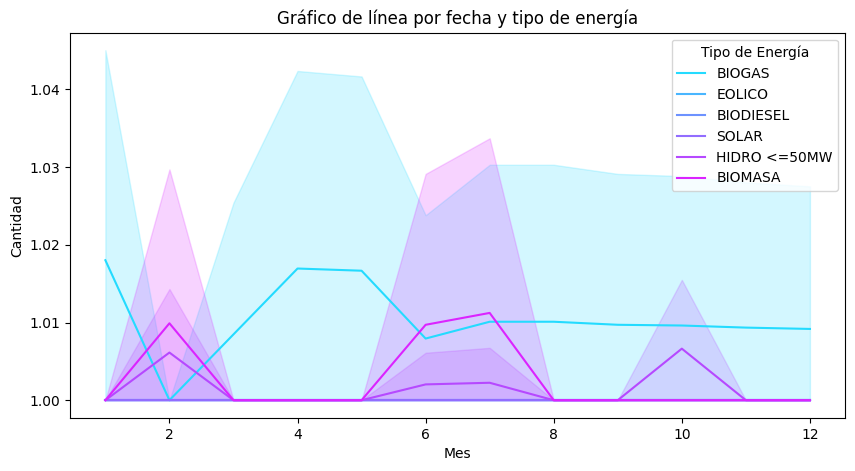

In [22]:
# Filtrar y seleccionar las columnas deseadas
grupo_df_filtrado = grupo_df[['fuente_de', 'anio', 'mes', 'CANTIDAD']]

# Crear un gráfico de línea
sns.set_palette('cool')
plt.figure(figsize=(10, 5))
sns.lineplot(data=grupo_df_filtrado, x='mes', y='CANTIDAD', hue='fuente_de', markers=True)

# Añadir etiquetas y título
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.title('Gráfico de línea por fecha y tipo de energía')

# Mostrar la leyenda
plt.legend(title='Tipo de Energía', bbox_to_anchor=(1, 1))

# Mostrar el gráfico
plt.show()

En este gráfico, podemos observar que la produccíon de algunas energías varía según el mes del año.

## 4. Cantidad de energía generada por provincia

## **Mapa de energía generada por año por cada provincia**

Sumamos a nuestro dataset original un archivo con datos geoespaciales proveniente del Instituto Geográfico Nacional.

In [23]:
# Leemos el archivo shape que tiene los polígonos de las provincias.

prov=gdp.read_file('../Datos/arg.shp')
prov.head(5)

#La columna fna contiene el nombre de las provincias argentinas.
#La columna geometry contiene los polígonos a graficar de cada provincia.

,gid,entidad,fna,gna,nam,in1,fdc,sag,fdc2,geometry
0,1,0.0,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,02,IGN,IGN,NaN,"POLYGON ((-58.45535 -34.52776, -58.45404 -34.5..."
1,2,0.0,Provincia del Neuquén,Provincia,Neuquén,58,IGN,IGN,NaN,"POLYGON ((-70.39341 -36.15624, -70.39333 -36.1..."
2,3,0.0,Provincia de San Luis,Provincia,San Luis,74,IGN,IGN,NaN,"POLYGON ((-67.05547 -31.85605, -67.05000 -31.8..."
3,4,0.0,Provincia de Santa Fe,Provincia,Santa Fe,82,IGN,IGN,NaN,"POLYGON ((-61.04639 -27.99800, -61.00805 -27.9..."
4,11,0.0,Provincia del Chubut,Provincia,Chubut,26,IGN,IGN,NaN,"MULTIPOLYGON (((-66.69852 -45.24747, -66.69920..."


In [24]:
n_prov=len(prov['fna'])
print("Hay {} provincias y la Ciudad Autónoma de Buenos Aires".format(n_prov-1))

Hay 23 provincias y la Ciudad Autónoma de Buenos Aires


In [25]:
df=er.copy()
df.drop(['mes'], axis=1,inplace=True) #Eliminamos la columna del mes que no es de interés
df=df.groupby(['prov','anio']).sum('energia_gen').reset_index()

In [26]:
# Verificamos si existen la misma cantidad de provincias en ambos dataframe

display(Markdown('*Número de provincias del dataframe original:*'),len(df['prov'].unique()))
print(df['prov'].unique())
display(Markdown('*Número de provincias del shape:*'),len(prov['fna'].unique()))
print(prov['fna'].unique())

*Número de provincias del dataframe original:*

20

['BUENOS AIRES' 'CATAMARCA' 'CHACO' 'CHUBUT' 'CORDOBA' 'CORRIENTES'
 'JUJUY' 'LA PAMPA' 'LA RIOJA' 'MENDOZA' 'MISIONES' 'NEUQUÉN' 'RIO NEGRO'
 'SALTA' 'SAN JUAN' 'SAN LUIS' 'SANTA CRUZ' 'SANTA FE'
 'SANTIAGO DEL ESTERO' 'TUCUMAN']


*Número de provincias del shape:*

24

['Ciudad Autónoma de Buenos Aires' 'Provincia del Neuquén'
 'Provincia de San Luis' 'Provincia de Santa Fe' 'Provincia del Chubut'
 'Provincia de Mendoza' 'Provincia de Entre Ríos' 'Provincia de San Juan'
 'Provincia de Jujuy' 'Provincia de Santiago del Estero'
 'Provincia de Río Negro' 'Provincia de Corrientes'
 'Provincia de Misiones' 'Provincia de Salta' 'Provincia de Córdoba'
 'Provincia de Buenos Aires' 'Provincia de La Pampa'
 'Provincia de La Rioja' 'Provincia de Catamarca' 'Provincia de Tucumán'
 'Provincia del Chaco' 'Provincia de Formosa' 'Provincia de Santa Cruz'
 'Provincia Tierra del Fuego']


In [27]:
# Vemos que faltan provincias. Agregamos a Tierra del Fuego, Entre Rios y Formosa.

df = pd.concat([df, pd.DataFrame([('TIERRA DEL FUEGO', 2011,0)],columns=df.columns)],
    ignore_index=True)
df = pd.concat([df, pd.DataFrame([('ENTRE RIOS', 2011,0)],columns=df.columns)],
    ignore_index=True)
df = pd.concat([df, pd.DataFrame([('FORMOSA', 2011,0)],columns=df.columns)],
    ignore_index=True)

# Crear un rango de años únicos y provincias únicas
anios_unicos = range(df["anio"].min(), df["anio"].max() + 1)
provincias_unicas = df["prov"].unique()

# Crear todas las combinaciones posibles de año y provincia
combinaciones = [(anio, provincia) for anio in anios_unicos for provincia in provincias_unicas]

# Crear un nuevo GeoDataFrame con todas las combinaciones
nuevo_gdf = pd.DataFrame(combinaciones, columns=["anio", "prov"])

# Hacer un merge con el GeoDataFrame original para obtener los valores de energía generada
nuevo_gdf = nuevo_gdf.merge(df, on=["anio", "prov"], how="left").fillna(0)

# Renombrar la columna de energía generada
nuevo_gdf = nuevo_gdf.rename(columns={"energia_generada": "energia_generada_nueva"})

In [28]:
#Debemos unir los nombres de las provincias del dataframe er con prov.
#Utilizamos una coincidencia aproximada de cadenas de caracteres y nos quedamos con la coincidencia más alta.
lista_prov=list(prov['fna']) #Tranformamos en lista los nombres de las provincias.

#Eliminamos la Ciudad Autónoma de Buenos Aires ya que no la tenemos en el dataframe inicial er.
lista_prov.pop(0)

#Definimos una función que busca la coincidencia.
def match_regions(list1, list2):
    # Toma solo la mejor coincidencia
    matched = [process.extract(list1[i], list2, limit=1, scorer=fuzz.partial_ratio)[0][0] for i in range(0,len(list1))]

    return {key: value for (key, value) in zip(list1, matched)}

match_dict = match_regions(list(nuevo_gdf['prov']), lista_prov)
print(match_dict)

#Cambiamos el indice del dataframe para que coincida con el shape

#.map lo que hace es mapear el indice segun una función de entrada, en este caso, el diccionario que creamos.
nuevo_gdf['prov']=nuevo_gdf['prov'].map(match_dict)

#Combinamos el .shape y el dataframe en función de las provincias.

mer=prov.merge(nuevo_gdf,left_on='fna', right_on='prov',how='left')
#Eliminamos la primera fila que corresponde a la Ciudad Autónoma de Buenos Aires.
mer=mer.drop(0)

# Eliminamos columnas que no son de interés con el método drop

mer.drop(['entidad','gid','in1','fdc','sag','fdc2'], axis=1,inplace=True)
mer=mer.dropna()

{'BUENOS AIRES': 'Provincia de Buenos Aires', 'CATAMARCA': 'Provincia de Catamarca', 'CHACO': 'Provincia del Chaco', 'CHUBUT': 'Provincia del Chubut', 'CORDOBA': 'Provincia de Córdoba', 'CORRIENTES': 'Provincia de Corrientes', 'JUJUY': 'Provincia de Jujuy', 'LA PAMPA': 'Provincia de La Pampa', 'LA RIOJA': 'Provincia de La Rioja', 'MENDOZA': 'Provincia de Mendoza', 'MISIONES': 'Provincia de Misiones', 'NEUQUÉN': 'Provincia del Neuquén', 'RIO NEGRO': 'Provincia de Río Negro', 'SALTA': 'Provincia de Salta', 'SAN JUAN': 'Provincia de San Juan', 'SAN LUIS': 'Provincia de San Luis', 'SANTA CRUZ': 'Provincia de Santa Cruz', 'SANTA FE': 'Provincia de Santa Fe', 'SANTIAGO DEL ESTERO': 'Provincia de Santiago del Estero', 'TUCUMAN': 'Provincia de Tucumán', 'TIERRA DEL FUEGO': 'Provincia Tierra del Fuego', 'ENTRE RIOS': 'Provincia de Entre Ríos', 'FORMOSA': 'Provincia de Formosa'}


In [29]:
def update_map(year):
    ax.clear()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Filtra el GeoDataFrame por el año seleccionado
    filtered_gdf = mer[mer['anio'] == year]

    # Plotea el mapa
    im=filtered_gdf.plot(column='energia_gen', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax,alpha=0.8)
    ax.set_title(f'Energía Generada (GWh) por Provincia - Año {int(year)}')

    # Agregar un mapa base
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=mer.crs.to_string())

   # Elimina el colorbar anterior y crea uno nuevo
    if hasattr(ax, 'cax'):
        ax.cax.remove()  # Elimina la colorbar anterior
    cbar = fig.colorbar(im.get_children()[0], cax=cax)
    cbar.set_label('Energía Generada (MWh)')
    ax.cax = cbar.ax

    # Actualiza la visualización
    plt.draw()

<IPython.core.display.Javascript object>


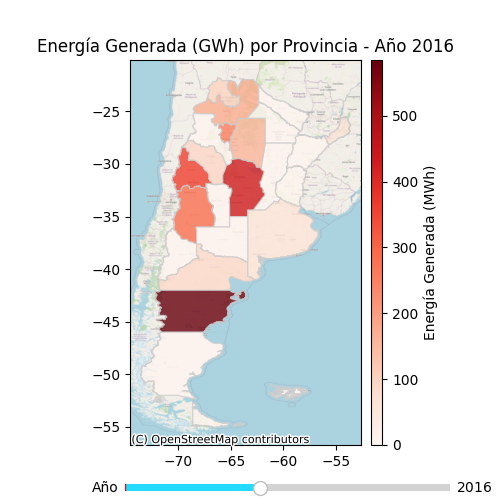

In [41]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
update_map(mer['anio'].min())  # Mostrar el mapa para el año mínimo inicialmente

# Agregar un slider
axcolor = 'lightgoldenrodyellow'
ax_slider = plt.axes([0.25, 0.01, 0.65, 0.03], facecolor=axcolor)
slider = Slider(ax_slider, 'Año', mer['anio'].min(), mer['anio'].max(), valinit=mer['anio'].min(), valstep=1)

# Función de actualización para el slider
def slider_update(val):
    update_map(slider.val)

slider.on_changed(slider_update)

plt.show()

Podemos observar que las provincias de Chubut y Buenos Aires son las que han crecido en su producción de energía renovable a lo largo de los años. Esto se debe principalmente a la creación y puesta en producción de parque eólicos. Esto nos da una pauta sobre cómo influye la posición geográfica en la energía renovable que prodomina en la provincia, relacionado al clima y a la geografía de ellas. 

## 5. Transformación de variables. 

Convertimos las variables categoricas <b>'fuente_de', 'region' y 'prov'</b> en su representación numerica.
A partir del métodod get_dummies se crean nuevas columnas para cada categoría única en la columna 'fuente_de' y asgina 1 o 0 según si la categoría está presente o no en cada fila. Finalmente se actualiza el DataFrame con las columnas creadas.

In [31]:
# Leemos nuevamente los datos de er
er_limpio = pd.read_csv('../Datos/er_limpio.csv')
er_limpio.drop('Unnamed: 0', axis=1, inplace=True)

In [32]:
categorias = pd.get_dummies(er_limpio['fuente_de'])
er_limpio = pd.concat([er_limpio.drop('fuente_de', axis = 1),categorias], axis = 1)

Veamos las diferencias claves entre **get_dummies** y **LabelEncoder**:


- get_dummies realiza one-hot encoding, creando columnas binarias para cada categoría (valores 0 o 1).

- LabelEncoder realiza integer encoding, asignando enteros a cada categoría única, comenzando en 0.

Bajo este contexto vamos a obtener como salida dos DataFrames por energía. Uno con LabelEncoder y otro sin, para evaluar cómo cambian los modelos según la entrada utilizada.

### DataFrames sin Label Encoder

Se eliminan todas las columnas que no serán usadas en el modelo, sólo se deja una fuente de energía por archivo.
Vamos a realizar un proceso iterativo donde se vaya guardando en archivos de salida diferentes cada una de las columnas de la energía con las columnas del año, mes y la cantidad de energía generada en GW.

In [33]:
col_exit = ['BIODIESEL', 'BIOGAS', 'BIOMASA', 'EOLICO', 'HIDRO <=50MW', 'SOLAR']

for columna in col_exit[0:]:
    # Seleccionar las columnas relevantes
    col_salida = ['anio','mes', 'region', 'prov', columna, 'energia_gen']
    df_salida = er_limpio[col_salida]

    #Nos quedamos con las filas que solo corresponden a la energía correspondiente.
    df_salida= df_salida[df_salida[columna] == 1]

    # Generar el nombre del archivo de salida
    nombre_archivo = "../Datos/er_{}.csv".format(re.sub(r'\W+', '', columna))
    ##Se utiliza la libreria re de expresiones regulares para evitar caracteres no alfanumericos.

    # Guardar el nuevo Dataset en un archivo CSV
    df_salida.to_csv(nombre_archivo, index=False)

### DataFrames con Label Encoder

Vamos a asignar enteros a cada categoría única de las columnas correspondiente a las provincias y a la región.

In [34]:
test_encoder = LabelEncoder()

In [35]:
er_limpio['prov'] = test_encoder.fit_transform(er_limpio['prov'])

In [36]:
test_encoder.classes_

array(['BUENOS AIRES', 'CATAMARCA', 'CHACO', 'CHUBUT', 'CORDOBA',
       'CORRIENTES', 'JUJUY', 'LA PAMPA', 'LA RIOJA', 'MENDOZA',
       'MISIONES', 'NEUQUÉN', 'RIO NEGRO', 'SALTA', 'SAN JUAN',
       'SAN LUIS', 'SANTA CRUZ', 'SANTA FE', 'SANTIAGO DEL ESTERO',
       'TUCUMAN'], dtype=object)

In [37]:
er_limpio['region'] = test_encoder.fit_transform(er_limpio['region'])

In [38]:
test_encoder.classes_

array(['BUENOS AIRES', 'CENTRO', 'COMAHUE', 'CUYO', 'GRAN BS.AS.',
       'LITORAL', 'NORESTE', 'NOROESTE', 'PATAGONIA'], dtype=object)

Vamos a realizar un proceso iterativo donde se vaya guardando en archivos de salida diferentes cada una de las columnas de la energía con las columnas del año, mes y la cantidad de energía generada en GW, en esta oportunidad con LabelEncoder

In [39]:
col_exit = ['BIODIESEL', 'BIOGAS', 'BIOMASA', 'EOLICO', 'HIDRO <=50MW', 'SOLAR']

for columna in col_exit[0:]:
    # Seleccionar las columnas relevantes
    col_salida = ['anio','mes', 'region', 'prov', columna, 'energia_gen']
    df_salida = er_limpio[col_salida]
    # Filtrar las filas con valor 1 en la columna 'f_SOLAR'
    df_salida= df_salida[df_salida[columna] == 1]

    # Generar el nombre del archivo de salida
    nombre_archivo = "../Datos/er_le_{}.csv".format(re.sub(r'\W+', '', columna))

    ##Se utiliza la libreria re de expresiones regulares para evitar caracteres no alfanumericos.

    # Guardar el nuevo Dataset en un archivo CSV
    df_salida.to_csv(nombre_archivo, index=False)

Vemos el ultimo DataFrame exportado

In [40]:
df_salida.head(5)

,anio,mes,region,prov,SOLAR,energia_gen
37,2011,1,3,14,True,0.0
80,2011,2,3,14,True,0.0
123,2011,3,3,14,True,0.1
166,2011,4,3,14,True,0.2
209,2011,5,3,14,True,0.2
